# Exercise 5. Exploratory Data Analysis (EDA) for paired data

## Task 1. Loading the dataset.
- Download `ibtracs.WP.list.v04r01.csv` from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/
- Store it in any folder, and then specify the path to that file in the `file_path` variable below.
- Load the full dataset.

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
file_path = '../../data/ibtracs.WP.list.v04r01.csv'

In [3]:
# Define columns to load
usecols = [
    'SID',        # Storm ID
    'SEASON',     # Year
    'LAT',        # Latitude
    'LON',        # Longitude
    'WMO_WIND',   # Wind speed (knots)
    'WMO_PRES',   # Central pressure (hPa)
    'STORM_SPEED',# Forward speed (km/h)
    'STORM_DIR',   # Forward direction (degrees)
    'ISO_TIME'
]

# df = pd.read_csv(file_path, low_memory=False)
df = pd.read_csv(
    file_path,
    skiprows=[1],        # Skip row 2 (units row)
    usecols=usecols,
    low_memory=False
)

# List of columns to convert to float
num_cols = ['WMO_WIND', 'WMO_PRES', 'STORM_SPEED', 'STORM_DIR']

# Convert to float using pd.to_numeric, forcing errors to NaN
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246395 entries, 0 to 246394
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SID          246395 non-null  object 
 1   SEASON       246395 non-null  int64  
 2   ISO_TIME     246395 non-null  object 
 3   LAT          246395 non-null  float64
 4   LON          246395 non-null  float64
 5   WMO_WIND     29693 non-null   float64
 6   WMO_PRES     70875 non-null   float64
 7   STORM_SPEED  246390 non-null  float64
 8   STORM_DIR    246390 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 16.9+ MB


In [4]:
null_counts = df.isnull().sum()
print("Null values per column:")
print(null_counts)

df.head()

Null values per column:
SID                 0
SEASON              0
ISO_TIME            0
LAT                 0
LON                 0
WMO_WIND       216702
WMO_PRES       175520
STORM_SPEED         5
STORM_DIR           5
dtype: int64


,SID,SEASON,ISO_TIME,LAT,LON,WMO_WIND,WMO_PRES,STORM_SPEED,STORM_DIR
0,1884177N17124,1884,1884-06-24 16:00:00,16.5,124.0,NaN,NaN,6.0,280.0
1,1884177N17124,1884,1884-06-24 18:00:00,16.5,123.8,NaN,NaN,6.0,280.0
2,1884177N17124,1884,1884-06-24 21:00:00,16.6,123.5,NaN,NaN,6.0,285.0
3,1884177N17124,1884,1884-06-25 00:00:00,16.7,123.2,NaN,NaN,6.0,285.0
4,1884177N17124,1884,1884-06-25 03:00:00,16.8,122.9,NaN,NaN,6.0,290.0


#### Questions
1. Are there missing values in the dataset? Which columns contain these missing values? <br>
**There are missing values in the WMO_WINDS, WMO_PRES, STORM_SPEED, and STORM_DIR columns.**
2. Based on the first few rows, what variables are available in this dataset, and what types of data do they contain?<br>
**The data is on cyclone/typhoon information, with information describing the typhoons' position, time of formation, position, direction, pressure and speed.**

Some useful commands
- `df.head()`
- `df.isnull()`

---
## Task 2: Filter and select data. 
While the IBTrACS dataset is complete, reliable wind data only exists post satellite era [1980 onwards](https://journals.ametsoc.org/view/journals/bams/91/3/2009bams2755_1.xml). Let's filter the dataset according to the column `SEASON`.

In [5]:
df['SEASON'] = df['SEASON'].astype(int)
df = df[(df['SEASON'] >= 1980) & (df['SEASON'] <= 2000)]

# Check shape and basic info
print("Rows:", df.shape[0], "| Columns:", df.shape[1])
df.info()

Rows: 57198 | Columns: 9
<class 'pandas.core.frame.DataFrame'>
Index: 57198 entries, 140402 to 197599
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SID          57198 non-null  object 
 1   SEASON       57198 non-null  int64  
 2   ISO_TIME     57198 non-null  object 
 3   LAT          57198 non-null  float64
 4   LON          57198 non-null  float64
 5   WMO_WIND     13642 non-null  float64
 6   WMO_PRES     20980 non-null  float64
 7   STORM_SPEED  57197 non-null  float64
 8   STORM_DIR    57197 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 4.4+ MB


#### Questions
1. After printing `df.info()`, compare the Non-Null counts between all the columns before and after filtering. What do you notice? Why do you think this is so? <br>
**The number of Non-Null counts decreased by a considerable amount for WMO_WIND and WMO_PRES variables. Since WMO was found in the 1950s, a standardized way of recording wind and pressure may have started after that point in time. Around this time as well, satellites were more widely used to record some variables remotely - which were able to reduce the amount of missing data.**

---
## Task 3: Summary Statistics
Calculate and interpret the summary statistics (mean, median, min, max, standard deviation) for each numeric column in the dataset. Remember, you can subset a specific column using the following syntax

```python
subset = df['COLUMN NAME HERE']
```

When you have your subset, you can then calculate the different summar statistics such as `mean`,  `median`, etc. 

For example 
```python
subset_mean = subset.mean()
```
If you want to operate from the df directly,

```python
subset_mean = df['COLUMN NAME HERE'].mean()
```

or alternatively
```python
print(df['COLUMN NAME HERE'].mean())
```

You can also choose to print out the summary statistics using `df.describe()`. The [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) lists other summary statistics that might be useful here.

In [16]:
subset_wind = df['WMO_WIND']
subset_pres = df['WMO_PRES']
subset_spd = df['STORM_SPEED']
subset_dir = df['STORM_DIR']
subset_arr = [subset_wind, subset_pres, subset_spd, subset_dir]
label = ['WMO_WIND', 'WMO_PRES', 'STORM_SPEED', 'STORM_DIR']

for i, subset in enumerate(subset_arr):
    subset_mean = subset.mean()
    subset_median = subset.median()
    subset_min = subset.min()
    subset_max = subset.max()
    subset_std = subset.std()

    print(f"{label[i]}: Mean: {subset_mean:.2f} Median: {subset_median} Minimum: {subset_min} Maximum: {subset_max} Standard Dev.:{subset_std:.2f}")

WMO_WIND: Mean: 59.00 Median: 55.0 Minimum: 15.0 Maximum: 150.0 Standard Dev.:19.63
WMO_PRES: Mean: 983.91 Median: 992.0 Minimum: 880.0 Maximum: 1018.0 Standard Dev.:22.07
STORM_SPEED: Mean: 11.00 Median: 10.0 Minimum: 0.0 Maximum: 104.0 Standard Dev.:7.36
STORM_DIR: Mean: 219.11 Median: 275.0 Minimum: 0.0 Maximum: 360.0 Standard Dev.:114.69


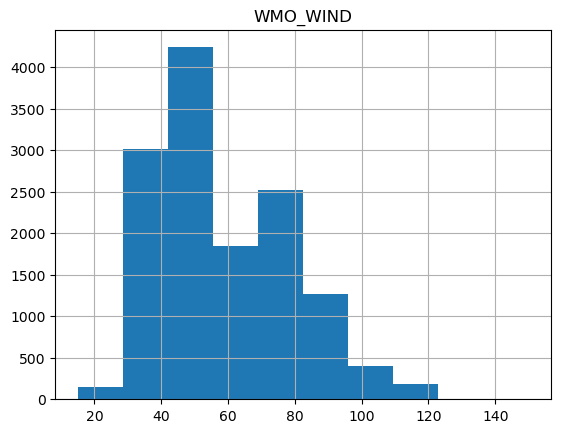

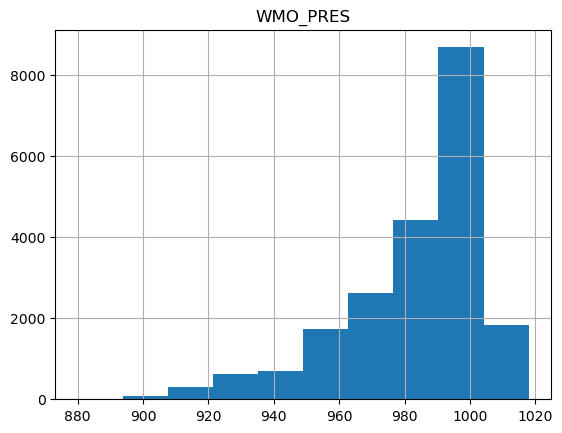

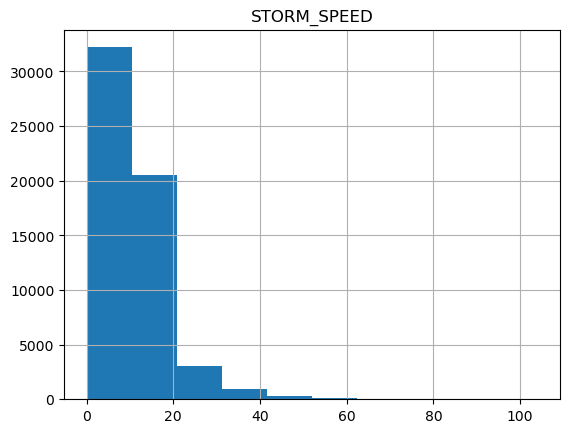

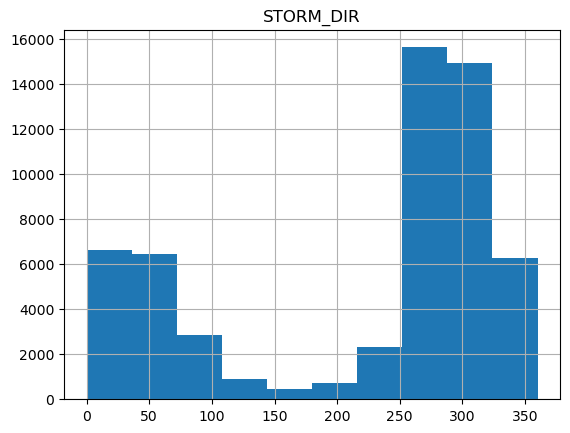

In [21]:
for i, subset in enumerate(subset_arr):
    plt.figure()
    subset.hist()
    plt.title(label[i])

### Questions:

1. Compare the mean and median values for `WMO_WIND`, `WMO_PRES`, `STORM_SPEED`, and `STORM_DIR`.
    - Are the mean and median close together, or far apart?<br>
**The mean and median for WMO_WIND, WMO_PRES, and STORM_SPEED are relatively close. However, STORM_DIR have values that are far apart.**
    - What might that tell you about the shape or skewness of each distribution? HINT: you can plot the histograms using `df['COLUM NAME HERE'].hist()`<br>
**The close mean and median values tell us that the distributions are close to a normal distribution. If these values are far apart, this might mean that the shape of the distribution is unusual.**
2. Take a look at the standard deviation for the different variables.
    - Which variable has the largest standard deviation?<br>
**The largest standard deviation is shown in the STORM_DIR data.**
    - What does this suggest about how that variable behaves across storms?<br>
**This shows that the movement of a storm is less predictable than its other variables. However, some actions, like isolating to a certain area in the globe, might reduce this standard deviation.**

---
## Task 4a: Paired EDA: Scatterplots
In this section, you'll explore how two storm-related variables relate to each other using scatterplots and correlation.

1. Copy or duplicate the cell below. Use as many cells as you can.
2. Change x_var and y_var to any two numeric columns (e.g., `WMO_WIND`, `WMO_PRES`, `STORM_SPEED`, `STORM_DIR`,`LAT`, `LON` ). Do not plot `LAT` vs `LON` together yet, we'll tackle that in Task 4b. 
3. Run the cell to generate a scatterplot and print the Pearson correlation (r) and p-value.
4. Try different variable combinations. Look for patterns, clusters, and outliers.

For this step, you should produce a minimum of two scatterplots.

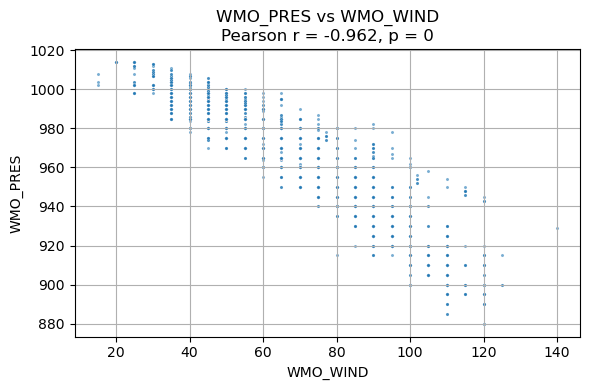

In [22]:
x_var = 'WMO_WIND'
y_var = 'WMO_PRES'

subset = df[[x_var, y_var]].dropna()

r_value, p_value = pearsonr(subset[x_var], subset[y_var])

plt.figure(figsize=(6, 4))
sns.scatterplot(data=subset, x=x_var, y=y_var, alpha=0.6, s=5)

plt.title(f'{y_var} vs {x_var}\nPearson r = {r_value:.3f}, p = {p_value:.3g}')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid(True)
plt.tight_layout()
plt.show()

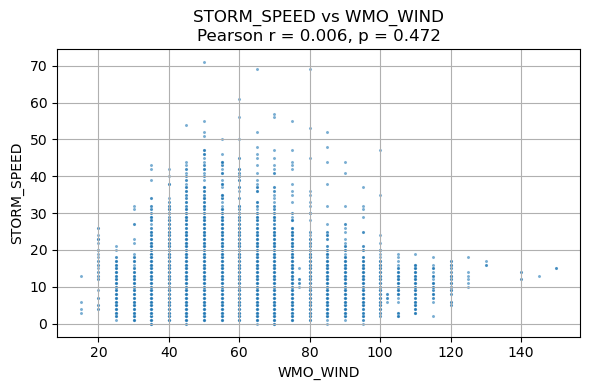

In [63]:
x_var = 'WMO_WIND'
y_var = 'STORM_SPEED'

subset = df[[x_var, y_var]].dropna()

r_value, p_value = pearsonr(subset[x_var], subset[y_var])

plt.figure(figsize=(6, 4))
sns.scatterplot(data=subset, x=x_var, y=y_var, alpha=0.6, s=5)

plt.title(f'{y_var} vs {x_var}\nPearson r = {r_value:.3f}, p = {p_value:.3g}')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid(True)
plt.tight_layout()
plt.show()

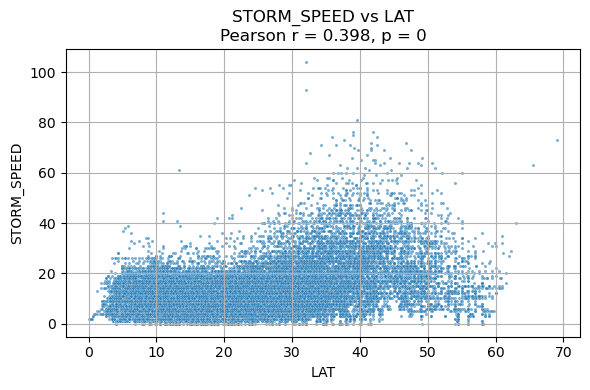

In [56]:
x_var = 'LAT'
y_var = 'STORM_SPEED'

subset = df[[x_var, y_var]].dropna()

r_value, p_value = pearsonr(subset[x_var], subset[y_var])

plt.figure(figsize=(6, 4))
sns.scatterplot(data=subset, x=x_var, y=y_var, alpha=0.6, s=5)

plt.title(f'{y_var} vs {x_var}\nPearson r = {r_value:.3f}, p = {p_value:.3g}')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid(True)
plt.tight_layout()
plt.show()

### Questions
1. From your selected pairs, which variable pairs showed the strongest correlation? Did this match what you expected based on storm behavior?<br>
**WMO_PRES and WMO_WIND show a high correlation. This makes sense, as lower pressure corresponds to higher temperature gradients, resulting in stronger storms (with faster winds).**
2. Did any variable pairs surprise you with their correlation (or lack of it)?<br>
**I thought that STORM_DIR would have some relation to LAT/LON, but it does not seem to be the case.**
3. Did you observe any strong-looking relationships that weren't linear?<br>
**STORM_SPEED and LAT show an unusual non-linear relationship, with storm speed increasing at the mid latitudes.**
4. Are there any variables you think are related but not captured well by Pearson’s r? Why might that be?<br>
**I imagine STORM_SPEED differs with LAT values, since mid-latitude storms would have more synoptic forces pulling them to different directions. Pearson's r isn't able to capture this, because the relationship is not necessarily linear.**

---
## Task 4b: Paired EDA: Scatterplots for Specific Subsets.
Use the script below to plot and calculate the p-values for the variable pairs `LAT` and `LON`. In the next cell, let us clip the `LON` values to below 180 degrees East. 

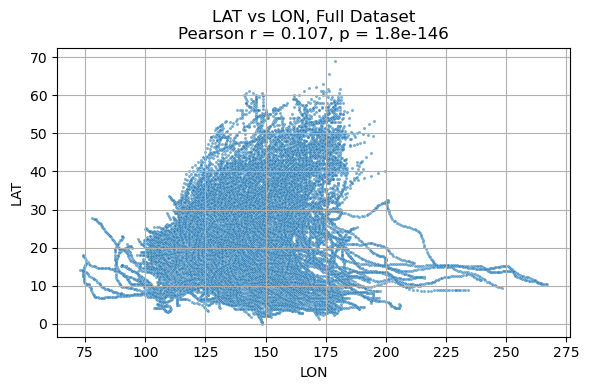

In [64]:
# Set your variables
x_var = 'LON'
y_var = 'LAT'

# Subset 1: All valid values (no clipping)
subset_all = df[[x_var, y_var]].dropna()
r_all, p_all = pearsonr(subset_all['LON'], subset_all['LAT'])
plt.figure(figsize=(6, 4))
sns.scatterplot(data=subset_all, x=x_var, y=y_var, alpha=0.6, s=5)

plt.title(f'{y_var} vs {x_var}, Full Dataset\nPearson r = {r_all:.3f}, p = {p_all:.3g}')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid(True)
plt.tight_layout()
plt.show()

r_all, p_all = pearsonr(subset_all['LON'], subset_all['LAT'])

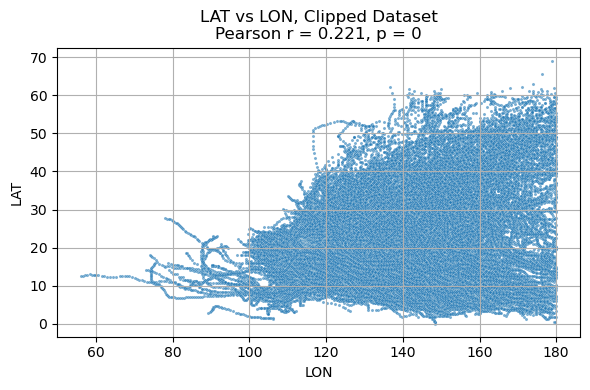

In [26]:
# Subset 2: Clip to only longitudes <= 180
subset_clipped = subset_all[subset_all['LON'] <= 180]
r_clip, p_clip = pearsonr(subset_clipped['LON'], subset_clipped['LAT'])
plt.figure(figsize=(6, 4))
sns.scatterplot(data=subset_clipped, x=x_var, y=y_var, alpha=0.6, s=5)

plt.title(f'{y_var} vs {x_var}, Clipped Dataset\nPearson r = {r_clip:.3f}, p = {p_clip:.3g}')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid(True)
plt.tight_layout()
plt.show()

### Questions
1. The correlation becomes stronger after clipping. Why?<br>
**Since the paths of typhoons are isolated to a certain location, there might be long lasting systems that are common in that area that will, more often than not, determine the movement of the typhoon. Because of this, there are less outliers, and this makes the relationship appear more linear.**
2. What does this tell us about the importance of pre-processing spatial data?<br>
****
3. If you only looked at the correlation value (`r`), would you have noticed that something was off in the data? Why or why not?<br>
****

---
## Task 5: Paired EDA: Correlation Matrix
In this section, you'll generate a correlation matrix to explore how several storm-related variables relate to each other at once.

1. Select a group of numeric columns you'd like to compare.
2. Drop rows with missing values.
3. Use pandas to calculate the correlation matrix (`.corr()`).
4. Use `seaborn.heatmap()` to visualize the result.

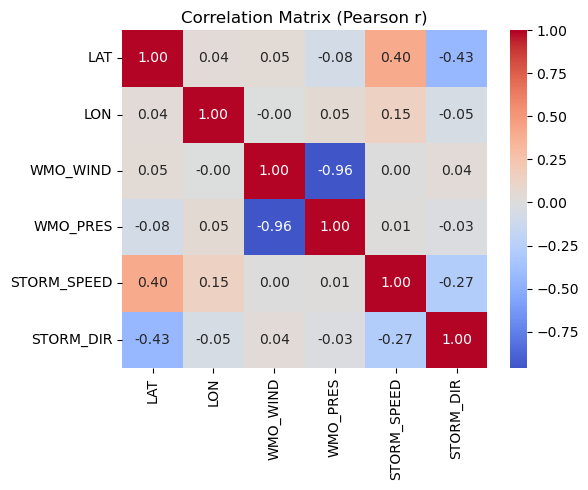

In [28]:
# Select numeric variables of interest. Fill this in with as many variables as you can.
vars_to_compare = []

# Drop rows with missing values in these columns
df_corr = df[vars_to_compare].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix (Pearson r)")
plt.tight_layout()
plt.show()

### Questions:
1. Which variable pairs have the strongest positive or negative correlations?<br>
****
2. Some variables show weak or near-zero correlation.
   - Are there any surprising cases where you expected a stronger relationship?<br>
****
   - Could this be due to non-linear behavior or noise?<br>
****
3. `STORM_DIR` represents storm movement direction in degrees, where 0° and 360° both point north. This means it’s a circular variable, and special care is needed when interpreting correlations. The correlation between `STORM_SPEED` and `STORM_DIR` and between `LAT` and `STORM_DIR` is quite high. Why might these values be misleading? Can we trust these correlation values as-is, given that direction wraps around at 360°?<br>
****

Note: We will further explore the `STORM_DIR` variable in Task 7. 

---
## Task 6a: Pearson vs Spearman (Scatterplots)
In this task, you’ll take a closer look at some variable pairs where the Pearson correlation coefficient is low, even though there seems to be a visible relationship in the scatterplot. Spearman’s rank correlation coefficient (ρ) measures the strength and direction of a monotonic relationship between two variables.

This often happens when the relationship is:
- Nonlinear (e.g., curved or dome-shaped)
- Monotonic but not linear (one direction but uneven)
- Affected by outliers or skewed values
- Or, in the case of `STORM_DIR`, when a variable is circular


When to use Spearman's rank correlation:
- When the scatterplot shows a curved trend (e.g., dome or S-shape)
- When the data contains outliers
- When the relationship is not linear, but still has an overall direction

### Instructions:
1. Revisit the correlation matrix from Task 5.
2. Look for variable pairs with low or near-zero r-values (e.g., r < 0.2).
3. Pick one of them to explore more deeply.
4. Use the provided script (scatterplot + Pearson + Spearman) to visualize the relationship.
5. Start by exploring the following pair: `LAT` vs `WMO_WIND`
6. After this, try another variable pair of your choice from the matrix.

In [ ]:
x_var = 
y_var = 

# Drop rows with missing values
subset = df[[x_var, y_var]].dropna()

# Calculate correlations
r_pearson, p_pearson = pearsonr(subset[x_var], subset[y_var])
rho_spearman, p_spearman = spearmanr(subset[x_var], subset[y_var])

# Scatterplot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=subset, x=x_var, y=y_var, alpha=0.6, s=5)

# Show both correlation results in the title
plt.title(f"{y_var} vs {x_var}\n"
          f"Pearson r = {r_pearson:.3f}, p = {p_pearson:.1e} | "
          f"Spearman ρ = {rho_spearman:.3f}, p = {p_spearman:.1e}")
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid(True)
plt.tight_layout()
plt.show()

### Questions
1. Do you see a visible relationship in the scatterplot, even if Pearson’s r is low? What shape or structure do you observe?<br>
****
2. How does Spearman’s ρ compare to Pearson’s r? In what situations is Spearman more useful than Pearson?<br>
****
3. Based on what you saw, should we rely only on the correlation matrix when analyzing data? Why or why not?<br>
****
4. Can you think of any physical or meteorological reason why the pattern appears curved or dome-shaped?<br>
****

---
## Task 6b: Pearson vs Spearman Heatmaps

In this section, you’ll create a correlation matrix using Spearman’s ρ instead of Pearson’s r. This can help you detect monotonic relationships that may not be linear.

- Use the same variables you explored in Task 5.
- Calculate the Spearman correlation matrix using `.corr(method='spearman')`.
- Visualize the result using `seaborn.heatmap()`.

In [ ]:
# Select numeric variables of interest. Fill this in with as many variables as you can.
vars_to_compare = []

# Drop rows with missing data
df_corr = df[vars_to_compare].dropna()

# Compute correlation matrices
pearson_corr = df_corr.corr(method='pearson')
spearman_corr = df_corr.corr(method='spearman')

# Set up subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Pearson heatmap
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0, fmt=".2f", ax=axes[0])
axes[0].set_title("Pearson Correlation (r)")

# Spearman heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0, fmt=".2f", ax=axes[1])
axes[1].set_title("Spearman Correlation (ρ)")

plt.tight_layout()
plt.show()

### Questions
1. Which variable pairs have noticeably different values between Pearson and Spearman?<br>
****
    - Which correlation is stronger? Why might that be?<br>
****
2. Pick one pair where the values differ significantly. What does the scatterplot look like? Does it seem linear, nonlinear, or ranked but curved?<br>
****
3. When should we prefer Spearman’s correlation over Pearson’s in weather or climate data? What types of variables (e.g., direction, skewed values) are better handled by Spearman?<br>
****

---
## Task 7: Exploring Circular Data (Storm Direction)

In this task, you’ll explore how to visualize and interpret circular variables, like STORM_DIR, which represents storm movement direction in degrees (0–360).

Because direction wraps around (0° - 360°), it can’t be meaningfully analyzed using traditional linear statistics or plots.

Use the code below to plot a circular histogram.

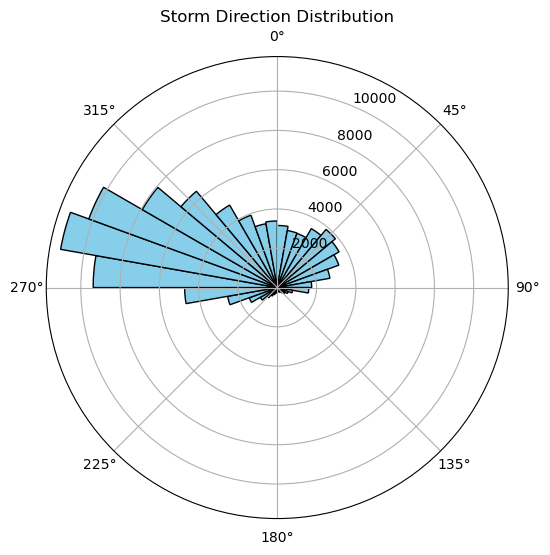

In [29]:
# Drop NaN and convert degrees to radians
radians = np.deg2rad(df['STORM_DIR'].dropna())

# Plot polar histogram
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.hist(radians, bins=36, color='skyblue', edgecolor='black')

ax.set_theta_zero_location("N")  # Set 0° at the top
ax.set_theta_direction(-1)       # Clockwise
ax.set_title("Storm Direction Distribution")
plt.show()

### Questions
1. What directions do most storms tend to move toward? Are they clustered in one direction or spread out?<br>
****
2. Is the distribution symmetric? Are there dominant storm paths? Do any compass directions have very few storms?<br>
****
3. What might explain this pattern?<br>
****

---
## Task 8: Reexpressing Circular Data

In this final task, you’ll reflect on what happens when we re-express circular variables (like `STORM_DIR`) into linear vector components (`DIR_U` and `DIR_V`), and how this transformation helps us better understand storm behavior.

This allows us to:
- Use these in scatterplots and correlation
- Make more meaningful comparisons with other linear variables like `LAT`, `STORM_SPEED`, or `WMO_WIND`

Run the code below to convert STORM_DIR to radians and compute DIR_U and DIR_V:

In [30]:
# Drop NaNs and convert to radians
df['DIR_rad'] = np.deg2rad(df['STORM_DIR'])

# Re-express direction as unit vectors
df['DIR_U'] = np.cos(df['DIR_rad'])  # East-West component
df['DIR_V'] = np.sin(df['DIR_rad'])  # North-South component


Copy the cells in Task 6b where we plotted the correlation heatmaps. Update this to include `DIR_U` and `DIR_V`.

From the correlation heatmaps, choose one variables with moderate Pearson or Spearman to compare with `DIR_U` and one with `DIR_V`, and create scatterplots. You can copy the cells in 6a. 

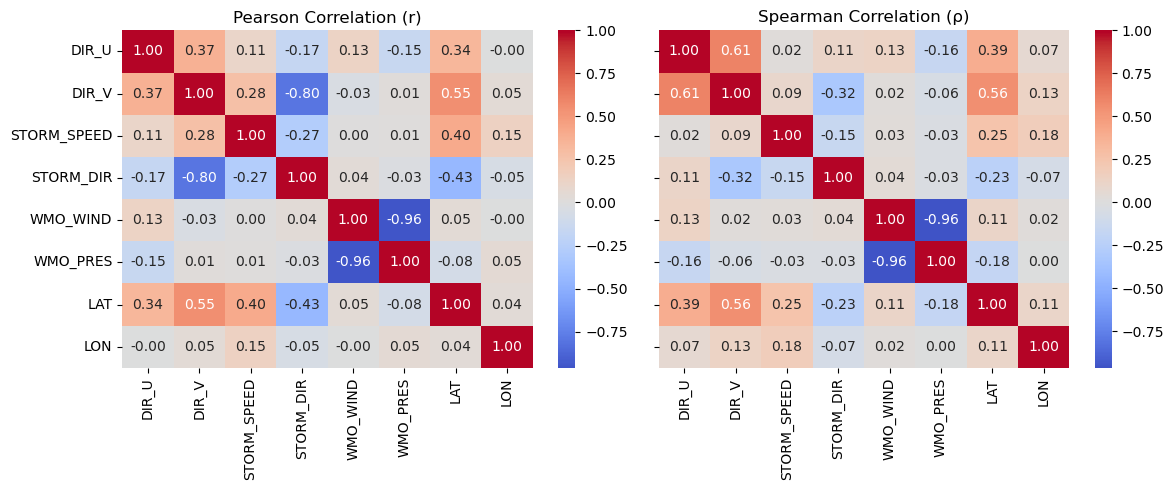

### Questions
1. How do the new variables `DIR_U` and `DIR_V` behave in the correlation matrix? Do they show stronger or weaker relationships than `STORM_DIR`?<br>
****
2. For your selected scatterplots, do Pearson and Spearman correlation agree?<br>
****
3. Which component (U or V) seems more related to the other storm characteristics (e.g., speed, latitude)?<br>
****

---
## Task 9: Plotting on a map. 

In this final task, you’ll plot all the IBTrACS storm data points on a map using `LONGITUDE` and `LATITUDE`. You’ll use color to represent storm wind speed (`WMO_WIND`) and movement speed (`STORM_SPEED`) so that you can see where the strongest and fastest storms tend to occur.

You can also modify the script below to plot other variables.

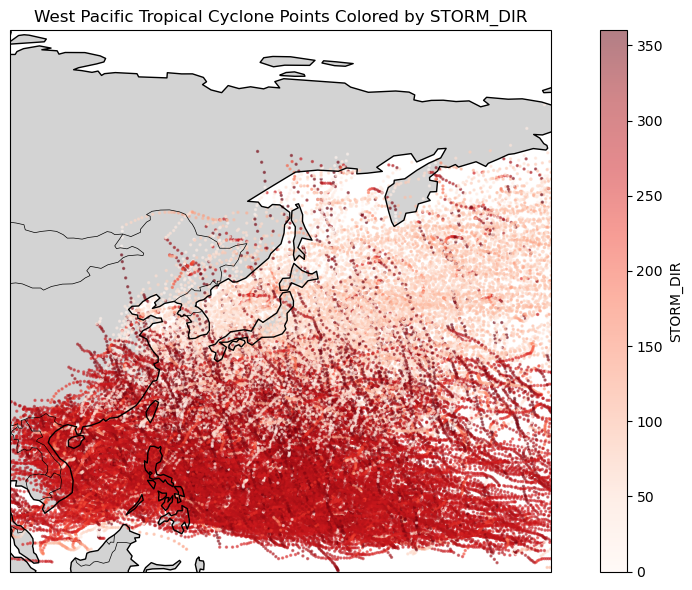

In [41]:
var_to_plot = ''
cmap = 'Reds'
point_size = 2

# Drop missing data
df_map = df[['LON', 'LAT', var_to_plot]].dropna()

# Set up the map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to West Pacific: [lon_min, lon_max, lat_min, lat_max]
ax.set_extent([100, 180, 0, 80], crs=ccrs.PlateCarree())

# Add base features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot storm points
sc = ax.scatter(
    df_map['LON'], df_map['LAT'],
    c=df_map[var_to_plot],
    cmap=cmap,
    s=point_size,
    alpha=0.5,
    transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label=var_to_plot)
ax.set_title(f"West Pacific Tropical Cyclone Points Colored by {var_to_plot}")
plt.tight_layout()
plt.show()


### Questions
1. Where do the highest wind speeds (`WMO_WIND`) appear on the map? How about fastest movement speeds (`STORM_SPEED`)? How about direction (`STORM_DIR`)?<br>
****
2. Are there any clear patterns related to latitude or longitude? Are certain storm behaviors (fast, strong) more common in the tropics vs mid-latitudes?<br>
****
3. Did anything surprise you about the spatial distribution?<br>
****

---

### Final Questions
1. Which variable relationships stood out to you as the most interesting or surprising? Did the visual patterns match the correlation numbers?<br>
****
2. When did Pearson’s correlation work well and when did it fail? How did Spearman’s or visual inspection help in those cases?<br>
****
3. How did mapping storm points help confirm or challenge your earlier observations? What additional insights did the spatial view give you?<br>
****